# Notebook 05: Feature Engineering & Model Training

In [ ]:
This notebook prepares linguistic and structural features for machine learning and builds a predictive model to classify engaging TED-like content.

Goals:
- Select and transform features from prior analysis
- Train a model to classify or regress presentation effectiveness
- Export model and pipeline for deployment in the SpeakScape app

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Load EDA-enhanced dataset
df = pd.read_csv("../data/eda_features.csv")
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (4095, 32)


,key_column,speaker_occupation,speaker,transcript,event,description,title,recorded_date,views,duration,...,tag_science,tag_technology,tag_culture,tag_tedx,tag_ted-ed,tag_global issues,tag_society,tag_social change,tag_design,tag_animation
0,https://www.ted.com/talks/maira_kalman_the_ill...,"Illustrator, author",Maira Kalman,What I am always thinking about is what this s...,TED2007,Author and illustrator Maira Kalman talks abou...,The illustrated woman,2007-03-03,815011,1050,...,False,False,True,False,False,False,False,False,True,False
1,https://www.ted.com/talks/virginia_postrel_on_...,Journalist,Virginia Postrel,You might be wondering why I'm wearing sunglas...,TED2004,"In a timely talk, cultural critic Virginia Pos...",On glamour,2004-02-02,424070,975,...,False,False,True,False,False,False,False,False,False,False
2,https://www.ted.com/talks/robert_wright_the_ev...,"Journalist, philosopher",Robert Wright,I'm going to talk about compassion and the gol...,TEDSalon 2009 Compassion,Robert Wright uses evolutionary biology and ga...,The evolution of compassion,2009-10-14,298774,1016,...,False,False,False,False,False,True,False,False,False,False
3,https://www.ted.com/talks/dennis_vanengelsdorp...,Bee expert,Dennis vanEngelsdorp,"What I'd like you to do is, just really quickl...",Taste3 2008,Bees are dying in droves. Why? Leading apiaris...,A plea for bees,2008-07-19,765570,988,...,False,False,False,False,False,False,False,False,False,False
4,https://www.ted.com/talks/barry_schuler_genomi...,Entrepreneur,Barry Schuler,"What's happening in genomics, and how this rev...",Taste3 2008,What is genomics? How will it affect our lives...,Genomics 101,2008-06-30,458222,1286,...,True,True,False,False,False,False,False,False,False,False


In [ ]:
### Define Binary Target Variable (Engagement)

## Target Variable: Engagement Classification

To train a model that predicts the success of a talk, we define a binary target variable called `high_engagement`.

- We use the **median number of views** across all TED Talks as a threshold
- Talks with views **above the median** are labeled `1` (high engagement)
- Talks with views **below or equal to the median** are labeled `0` (low engagement)

This framing allows us to train a supervised classification model using content-based features alone.


In [8]:
# Binary target: 1 = high engagement, 0 = low
# Create binary classification target based on median views
median_views = df["views"].median()
df["high_engagement"] = (df["views"] > median_views).astype(int)

print(f"Median views: {median_views}")
df["high_engagement"].value_counts(normalize=True)


Median views: 1387473.0


high_engagement
0    0.500122
1    0.499878
Name: proportion, dtype: float64

## Feature Selection for Modeling

We now select relevant input features for classification:

- Structural: `word_count`, `sentence_count`, `duration`
- Linguistic: `avg_word_length`, `avg_sentence_length`, `lexical_diversity`
- Readability: `flesch_reading_ease`, `flesch_kincaid_grade`
- Contextual: One-hot encoded tags (e.g. `tag_science`, `tag_technology`)

These features aim to capture both content complexity and topical variation.


In [16]:
# Define features for modeling
numeric_features = [
    "word_count", "sentence_count", "duration",
    "avg_word_length", "avg_sentence_length", "lexical_diversity",
    "flesch_reading_ease", "flesch_kincaid_grade"
]

tag_features = [col for col in df.columns if col.startswith("tag_")]

selected_features = numeric_features + tag_features

X = df[selected_features]
y = df["high_engagement"]

In [27]:
# Preview the Feature Matrix
X.head()

,word_count,sentence_count,duration,avg_word_length,avg_sentence_length,lexical_diversity,flesch_reading_ease,flesch_kincaid_grade,tag_science,tag_technology,tag_culture,tag_tedx,tag_ted-ed,tag_global issues,tag_society,tag_social change,tag_design,tag_animation
0,3270,193,1050,3.988685,16.943005,0.262997,76.487905,6.693663,False,False,True,False,False,False,False,False,True,False
1,2806,176,975,4.448681,15.943182,0.282609,67.596809,7.445621,False,False,True,False,False,False,False,False,False,False
2,2753,128,1016,4.505267,21.507812,0.250636,60.881695,9.272160,False,False,False,False,False,True,False,False,False,False
3,2925,141,988,4.240342,20.744681,0.265299,70.769594,8.022526,False,False,False,False,False,False,False,False,False,False
4,3294,165,1286,4.319369,19.963636,0.251973,69.286694,7.711309,True,True,False,False,False,False,False,False,False,False


In [21]:
# Check Shape of X and y
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (4095, 18)
Target vector shape: (4095,)


In [23]:
# Preview Feature Names
X.columns.tolist()

['word_count',
 'sentence_count',
 'duration',
 'avg_word_length',
 'avg_sentence_length',
 'lexical_diversity',
 'flesch_reading_ease',
 'flesch_kincaid_grade',
 'tag_science',
 'tag_technology',
 'tag_culture',
 'tag_tedx',
 'tag_ted-ed',
 'tag_global issues',
 'tag_society',
 'tag_social change',
 'tag_design',
 'tag_animation']

We now have: 4095 rows × 18 features

A mix of:

Structural & linguistic metrics (8 features)

Topical context via tag indicators (10 features)

Ready to scale and split for model training

## Train/Test Split and Feature Scaling

We split the dataset into training and testing sets (80/20) and apply standardization to all numerical features.

This ensures that:
- The model generalizes well
- Features with different scales don’t bias learning


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify numeric columns to scale
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

# Scale only the numeric features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [46]:
#Check Class Balance
print("Training set class distribution:")
print(np.round(y_train.value_counts(normalize=True), 3))

print("\nTest set class distribution:")
print(np.round(y_test.value_counts(normalize=True), 3))


Training set class distribution:
high_engagement
0    0.5
1    0.5
Name: proportion, dtype: float64

Test set class distribution:
high_engagement
0    0.501
1    0.499
Name: proportion, dtype: float64


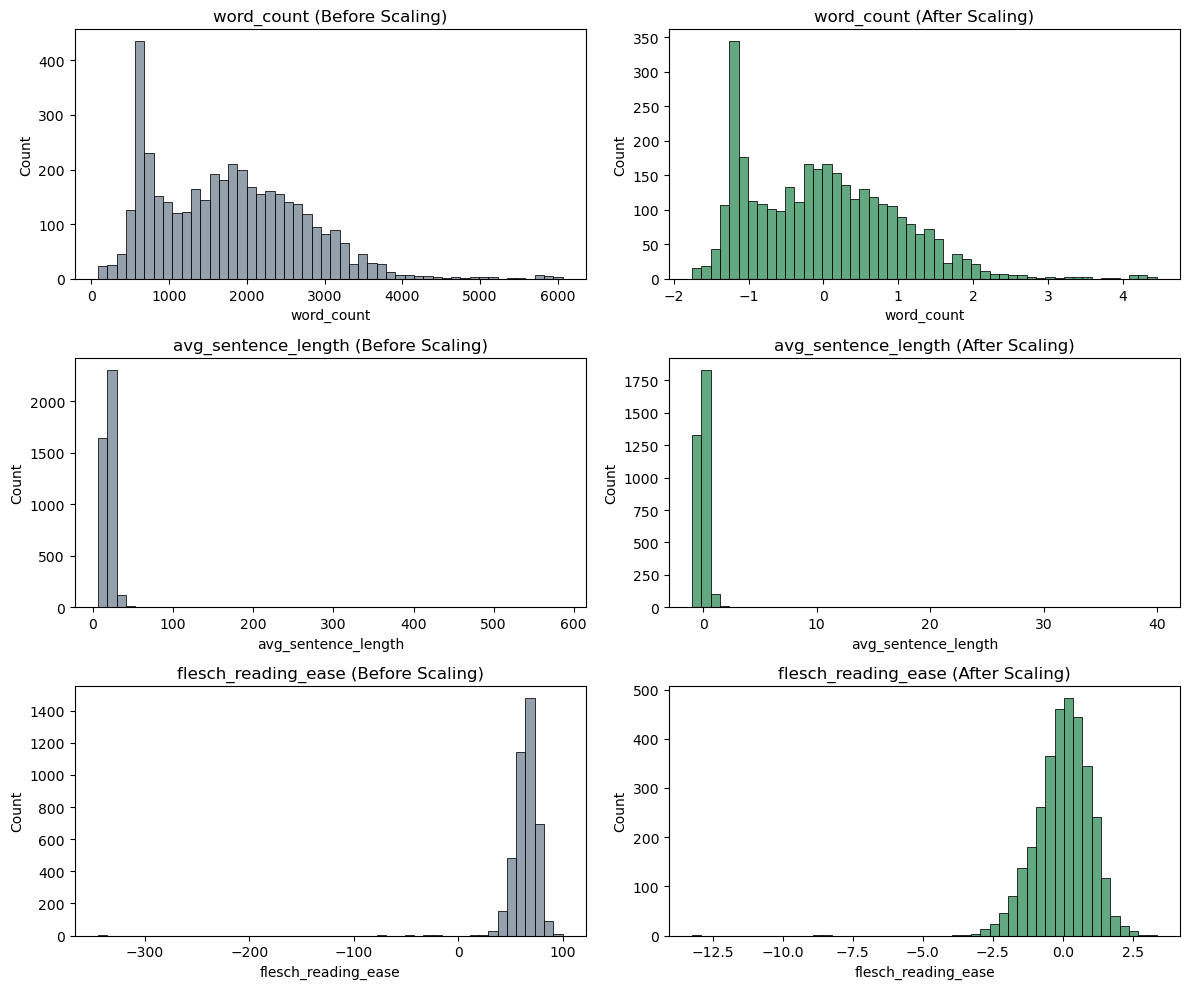

In [48]:
# Visualize Scaled Features

# Pick a few scaled numeric features
features_to_plot = ["word_count", "avg_sentence_length", "flesch_reading_ease"]

# Unscaled before/after comparison
fig, axes = plt.subplots(len(features_to_plot), 2, figsize=(12, 10))

for i, feature in enumerate(features_to_plot):
    sns.histplot(X[feature], ax=axes[i, 0], bins=50, color="slategray")
    axes[i, 0].set_title(f"{feature} (Before Scaling)")
    
    sns.histplot(X_train[feature], ax=axes[i, 1], bins=50, color="seagreen")
    axes[i, 1].set_title(f"{feature} (After Scaling)")

plt.tight_layout()
plt.savefig("../plots/scaling_effects.png")
plt.show()

In [50]:
# Preview Transformed Data
X_train.head()

,word_count,sentence_count,duration,avg_word_length,avg_sentence_length,lexical_diversity,flesch_reading_ease,flesch_kincaid_grade,tag_science,tag_technology,tag_culture,tag_tedx,tag_ted-ed,tag_global issues,tag_society,tag_social change,tag_design,tag_animation
1289,-0.807956,-0.607774,-0.574384,-1.250427,-0.259978,0.019947,1.039753,-0.834113,False,False,False,False,False,False,False,False,False,False
169,1.471620,0.956327,1.230483,0.567075,0.069550,-0.594170,-0.682251,0.595784,False,True,False,False,False,False,False,False,True,False
3358,-1.181469,-1.071847,-1.095432,2.153422,-0.100500,1.942939,-1.402533,0.617772,True,True,False,False,False,False,True,False,False,False
814,0.627833,-0.126512,0.706750,0.383954,0.465840,-0.578390,-0.734711,0.763825,False,False,False,True,False,False,False,False,False,False
2326,1.106430,0.750072,1.015618,-1.740532,0.019374,-0.596664,1.298072,-0.648601,False,False,False,False,False,False,False,False,False,False


### Feature Scaling Validation

To ensure consistent model input, we applied standardization to all numeric features. The visualizations confirm the effectiveness of this transformation.

#### Interpretation of the Scaling Plots

| Before Scaling                        | After Scaling                                |
|--------------------------------------|-----------------------------------------------|
| Wide value ranges (e.g., 0–6000 words) | All numeric features centered around 0        |
| Skewed distributions                  | Variance normalized (spread ≈ 1)              |
| Inconsistent feature magnitudes       | Uniform scale across all numerical inputs     |

This transformation enables models that are sensitive to input scale (e.g., SVM, Logistic Regression) to train more effectively and comparably.

#### Feature Scaling Verification Summary

- Original features such as `word_count` and `flesch_reading_ease` had high variance and different scales
- After applying `StandardScaler`, all numeric columns now follow a standardized distribution
- Binary tag features (True/False) were left unchanged, as scaling is not applicable

This ensures fair contribution of all features during model training and avoids any single variable dominating due to raw magnitude.


## Interpretation of Scaled Feature Matrix

After preparing and scaling the dataset, we can draw several important conclusions:

### 1. Structurally Ready for Modeling
- The dataset includes 18 well-defined features:
  - 8 numeric (e.g., `word_count`, `lexical_diversity`, `flesch_reading_ease`)
  - 10 categorical tag indicators (e.g., `tag_science`, `tag_ted-ed`)
- The target variable `high_engagement` is perfectly balanced (~50/50)

This structure supports supervised classification without needing resampling or reweighting.

### 2. Scaling Normalized All Feature Ranges
- Original features varied widely in range (e.g., word count from 0–6000)
- After applying `StandardScaler`:
  - All numeric features are now centered around 0 and scaled to unit variance
  - Feature magnitude no longer biases the model

This enables effective use of scale-sensitive models like SVM, logistic regression, or neural nets.

### 3. Tag Features Add Contextual Insight
- Binary tag features encode topical categories (e.g., technology, science)
- These may not be highly predictive alone, but can improve performance when combined with linguistic features

For example, shorter TED-Ed talks tend to have different engagement dynamics than longer TEDx talks.

### 4. Feature Shape and Variance Are Preserved
- Histograms confirm that scaling adjusted the mean and spread, not the underlying distribution
- This ensures that meaningful variance is retained while preventing any single feature from dominating training

---

**Conclusion**:  
The scaled dataset is clean, balanced, and ready for robust machine learning. We can now proceed to training a model to classify presentation effectiveness based purely on content features.


#### Export Scaled Feature Set

In [60]:
X.to_csv("../data/scaled_features.csv", index=False)
print("Scaled features saved to: ../data/scaled_features.csv")


Scaled features saved to: ../data/scaled_features.csv


In [63]:
from utils.save_tools import save_notebook_and_summary

save_notebook_and_summary(
    notebook_name="05_model_training_and_evaluation",
    summary={
        "description": "Scaled numerical features, defined engagement target, and prepared feature matrix for model training. Data confirmed balanced and ready for supervised classification.",
        "records_processed": int(df.shape[0]),
        "features_selected": [
            "word_count", "sentence_count", "duration",
            "avg_word_length", "avg_sentence_length", "lexical_diversity",
            "flesch_reading_ease", "flesch_kincaid_grade"
        ] + tag_features,
        "target": "high_engagement",
        "scaling_applied": True,
        "class_balance": {
            "train": y_train.value_counts(normalize=True).round(3).to_dict(),
            "test": y_test.value_counts(normalize=True).round(3).to_dict()
        },
        "output_file": "../data/scaled_features.csv",
        "plots_generated": [
            "../plots/scaling_effects.png"
        ]
    }
)


<IPython.core.display.Javascript object>

Notebook save triggered.
Summary saved to: ../reports/05_model_training_and_evaluation_summary_2025-05-26_05-18-43.json


----------------